## LSTM Model 5 - Male

The code was adapted from a blog post by Aishwarya Singh (2019) called 'A Hands-On Introduction to Time Series Classification (with Python Code)'.

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.preprocessing import sequence
from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

# fix random seed for reproducibility
np.random.seed(7)

Using TensorFlow backend.


In [2]:
# Load data and target
df = pd.read_csv('Seq_data_male.csv')

In [3]:
df.shape

(80707, 77)

In [4]:
# Load targets
targets = pd.read_csv('Seq_target_male.csv')

In [5]:
targets.shape

(4431, 1)

In [6]:
# Set sequence length
seq_len = 9

In [7]:
# Generate the sequences using Patient IDs
sequences = list()
patient_list = df['BrcId'].unique()
for patient in patient_list:
    values = df[df['BrcId']==patient].values
    sequences.append(values)

In [8]:
# Show the sequence stats
len_sequences = []
for one_seq in sequences:
    len_sequences.append(len(one_seq))
pd.Series(len_sequences).describe()

count    4431.000000
mean       18.214173
std        26.385823
min         3.000000
25%         6.000000
50%         9.000000
75%        19.000000
max       687.000000
dtype: float64

In [9]:
#truncate the sequence to length 9, pad values with -1
sequences=sequence.pad_sequences(sequences, maxlen=seq_len, padding='pre', dtype='float', truncating='pre', value=-1)

In [10]:
# Updated length is now 9 for all sequences
len_sequences = []
for one_seq in sequences:
    len_sequences.append(len(one_seq))
pd.Series(len_sequences).describe()

count    4431.0
mean        9.0
std         0.0
min         9.0
25%         9.0
50%         9.0
75%         9.0
max         9.0
dtype: float64

In [11]:
# Set the sequence data to df and targets to the target field
df = sequences
targets = np.array(targets['relapse_in_24M'])

In [12]:
# Split training and testing - 70/30
num_train_patients = round(.7*targets.shape[0])
num_test_patients = round(.3*targets.shape[0])

In [13]:
# Assign training and testing to index ranges
X_train = [df[i] for i in range(num_train_patients)] 
X_test = [df[i+num_train_patients] for i in range(num_test_patients)]
y_train = [targets[i] for i in range(num_train_patients)] 
y_test = [targets[i+num_train_patients] for i in range(num_test_patients)] 

In [14]:
# Convert to numpy arrays
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [15]:
X_train.shape

(3102, 9, 77)

In [16]:
# Remove BrcID
X_train= np.delete(X_train,0,axis=2)
X_test = np.delete(X_test,0,axis=2)

In [17]:
X_train.shape

(3102, 9, 76)

### Grid Search

This code was adapted from a blog post by Jason Brownlee (2019) called 'How to Grid Search Hyperparameters for Deep Learning Models in Python With Keras'.

In [34]:
# Use scikit-learn to grid search the batch size and epochs
# Function to create model, required for KerasClassifier
def create_model():
    model = Sequential()
    model.add(LSTM(100, input_shape=(seq_len, X_train.shape[2])))
    model.add(Dense(1, activation='sigmoid'))

    # Loss function is binary_crossentropy as it's binary classification, ADAM optimization algorithm
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# create model
model = KerasClassifier(build_fn=create_model, verbose=0)

# define the grid search parameters
batch_size = [10, 20, 30]
epochs = [10, 20, 50, 100]

param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid)
class_weight = {1:7.94, 0:1}
grid_result = grid.fit(X_train, y_train, class_weight=class_weight)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

C:\Users\LDwyer\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Best: 0.796583 using {'batch_size': 20, 'epochs': 100}
0.571567 (0.029238) with: {'batch_size': 10, 'epochs': 10}
0.728562 (0.036923) with: {'batch_size': 10, 'epochs': 20}
0.785945 (0.016979) with: {'batch_size': 10, 'epochs': 50}
0.779819 (0.012343) with: {'batch_size': 10, 'epochs': 100}
0.573179 (0.163458) with: {'batch_size': 20, 'epochs': 10}
0.643778 (0.005077) with: {'batch_size': 20, 'epochs': 20}
0.755964 (0.025285) with: {'batch_size': 20, 'epochs': 50}
0.796583 (0.003561) with: {'batch_size': 20, 'epochs': 100}
0.512573 (0.088947) with: {'batch_size': 30, 'epochs': 10}
0.635074 (0.025737) with: {'batch_size': 30, 'epochs': 20}
0.776918 (0.010486) with: {'batch_size': 30, 'epochs': 50}
0.793681 (0.007669) with: {'batch_size': 30, 'epochs': 100}


In [35]:
# Use scikit-learn to grid search the number of hidden units
# Function to create model, required for KerasClassifier
def create_model(units=25):
    model = Sequential()
    model.add(LSTM(units, input_shape=(seq_len, X_train.shape[2])))
    model.add(Dense(1, activation='sigmoid'))

    # Loss function is binary_crossentropy as it's binary classification, ADAM optimization algorithm
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# create model
model = KerasClassifier(build_fn=create_model, verbose=0, epochs=100, batch_size=20)

# define the grid search parameters
units = [50, 100, 150, 200, 250, 300]

param_grid = dict(units=units)
grid = GridSearchCV(estimator=model, param_grid=param_grid)
class_weight = {1:7.94, 0:1}
grid_result = grid.fit(X_train, y_train, class_weight=class_weight)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.793681 using {'units': 250}
0.778530 (0.008319) with: {'units': 50}
0.776596 (0.022941) with: {'units': 100}
0.785300 (0.009107) with: {'units': 150}
0.759510 (0.022918) with: {'units': 200}
0.793681 (0.011204) with: {'units': 250}
0.752418 (0.066345) with: {'units': 300}


### Build Model with best hyperparameters from Grid Search

In [51]:
# Create model with LSTM layer
model = Sequential()
model.add(LSTM(250, input_shape=(seq_len, X_train.shape[2])))
model.add(Dense(1, activation='sigmoid'))

# Early stopping (from Deep Learning with Python book, pg 250)
import keras
callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor='acc',
        patience=1,
    ),
    keras.callbacks.ModelCheckpoint(
        filepath='my_model.h5',
        monitor='val_loss',
        save_best_only=True,
    )
]

# Loss function is binary_crossentropy as it's binary classification, efficient ADAM optimization algorithm used
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [52]:
# Model summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_61 (LSTM)               (None, 250)               327000    
_________________________________________________________________
dense_61 (Dense)             (None, 1)                 251       
Total params: 327,251
Trainable params: 327,251
Non-trainable params: 0
_________________________________________________________________


In [53]:
# Fit model  
class_weight = {1:7.94, 0:1}
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=20
                    ,  class_weight = class_weight, callbacks=callbacks_list)

Train on 3102 samples, validate on 1329 samples
Epoch 1/100
3102/3102 [==============================] - 12s 4ms/step - loss: 1.3182 - acc: 0.4507 - val_loss: 0.6300 - val_acc: 0.7005
Epoch 2/100
3102/3102 [==============================] - 3s 840us/step - loss: 1.2655 - acc: 0.4655 - val_loss: 0.7128 - val_acc: 0.5237
Epoch 3/100
3102/3102 [==============================] - 3s 874us/step - loss: 1.2424 - acc: 0.5380 - val_loss: 0.8342 - val_acc: 0.3356
Epoch 4/100
3102/3102 [==============================] - 3s 891us/step - loss: 1.2355 - acc: 0.5158 - val_loss: 0.6749 - val_acc: 0.5809


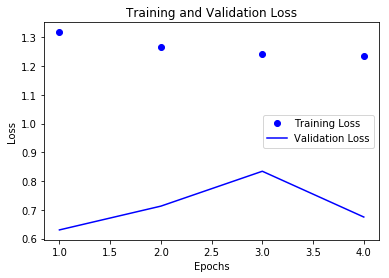

In [54]:
# Plot training and validation loss 
# Code provided by Chollet (2018, p. 74)

import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'bo', label='Training Loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

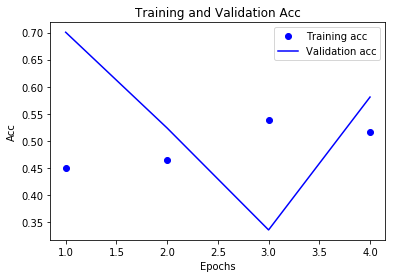

In [55]:
# Plot training and validation accuracy
# Code provided by Chollet (2018, p. 75)

plt.clf()
acc = history_dict['acc']
val_acc = history_dict['val_acc']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation Acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [56]:
# View the probability produced of each test record
# Code provided by Jason Brownlee (2019) in 'How to Calculate Precision, Recall, F1, and More for Deep Learning Models’

yhat_prob = model.predict(X_test)

In [57]:
# Code provided by Jason Brownlee (2019) in 'How to Calculate Precision, Recall, F1, and More for Deep Learning Models’

yhat_prob

array([[0.51973385],
       [0.56666905],
       [0.36716533],
       ...,
       [0.53442204],
       [0.4857457 ],
       [0.6836028 ]], dtype=float32)

In [58]:
# Predict classes for test set
# Code provided by Jason Brownlee (2019) in 'How to Calculate Precision, Recall, F1, and More for Deep Learning Models’

yhat_classes = model.predict_classes(X_test)

In [59]:
# Calculate additional metrics 
# Code provided by Jason Brownlee (2019) in 'How to Calculate Precision, Recall, F1, and More for Deep Learning Models’

from sklearn import metrics
accuracy = metrics.accuracy_score(y_test, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = metrics.precision_score(y_test, yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = metrics.recall_score(y_test, yhat_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = metrics.f1_score(y_test, yhat_classes)
print('F1 score: %f' % f1)

Accuracy: 0.580888
Precision: 0.154116
Recall: 0.543210
F1 score: 0.240109


In [60]:
# Confusion matrix 
# Code provided by Scikit-learn API Reference (2019)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, yhat_classes)

array([[684, 483],
       [ 74,  88]], dtype=int64)

In [61]:
# Code provided by Scikit-learn API Reference (2019)

tn, fp, fn, tp = confusion_matrix(y_test, yhat_classes).ravel()
tn, fp, fn, tp

(684, 483, 74, 88)

In [62]:
# AUC 
# Code provided by Scikit-learn API Reference (2019)

fpr, tpr, thresholds = metrics.roc_curve(y_test, yhat_classes, pos_label=1)
metrics.auc(fpr, tpr)

0.5646640642356152